In [192]:
import numpy as np
import os
import nibabel as nb
import pandas as pd
from nilearn.image import resample_to_img, math_img
from sklearn.cluster import KMeans

import sys
sys.path.append("/home/seojin/Seojin_commonTool/Module")

from surface_analysis import vol_to_surf, surface_cross_section

sys.path.append("/home/seojin")
import surfAnalysisPy as surf
import matplotlib.pylab as plt

# Params

In [336]:
reference_img = "/mnt/ext1/seojin/HR/exp_blueprint_0324v4/fMRI_data/output/roi/mask/group_mask.nii.gz"
surf_hemisphere = "R" # L: Left, R: right
surf_resolution = 32

surf_dir_path = "/mnt/sda2/Common_dir/Atlas/Surface"
pial_surf_path = os.path.join(surf_dir_path, f"fs_LR_{surf_resolution}", f"fs_LR.{surf_resolution}k.{surf_hemisphere}.pial.surf.gii")
white_surf_path = os.path.join(surf_dir_path, f"fs_LR_{surf_resolution}", f"fs_LR.{surf_resolution}k.{surf_hemisphere}.white.surf.gii")
template_surface_path = os.path.join(surf_dir_path, f"fs_LR_{surf_resolution}", f"fs_LR.{surf_resolution}k.{surf_hemisphere}.flat.surf.gii")

# Functions

In [337]:
def search_dict(dictionary, keywords):
    """
    Search keywords over values in dictionary 
    
    This function iterates dictionary using keys for searching keyword in value
    
    return: searched dictionary
    """
    keys = []
    infos = []
    for key in dictionary:
        is_not_matching = False
        for keyword in keywords:
            if keyword not in dictionary[key]:
                is_not_matching = True

        if is_not_matching == False:
            keys.append(key)
            infos.append(dictionary[key])
    return dict(zip(keys, infos))
    
class fan_roi_mask_manager:
    def __init__(self, fan_info_path, mask_dir_path, reference_img):
        """
        :params fan_info_path: fan roi path
        :params reference_img: reference_img for fitting shape
        """
        if type(reference_img) == str:
            reference_img = nb.load(reference_img)
        self.reference_img = reference_img
        
        # load fan info
        self.mask_fan_info = pd.read_csv(fan_info_path, header=None)
        self.mask_fan_info.index = self.mask_fan_info.index + 1 # roi file_name is started from 1
        self.mask_fan_info.index = list(map(lambda index: str(index).zfill(3), self.mask_fan_info.index)) # for matching filename format ex) 001
        self.mask_fan_info.columns = ["Description"]
        self.mask_fan_info = dict(self.mask_fan_info["Description"])
    
        self.mask_dir_path = mask_dir_path
        
    def search_mask_info(self, keywords):
        """
        search roi information using keywords
        
        :param keywords: keyword for searching ex) ["Rt", "prefrontal"]
        """
        searched_dict = search_dict(self.mask_fan_info, keywords)
        return searched_dict
    
    def search_roi(self, keywords, exclude_keywords = None):
        """
        :param keywords: keyword to search(list)
        """
        name = "_".join(keywords)
        if exclude_keywords != None:
            name += "_exclude_" + "_".join(exclude_keywords)
            
        return brain_mask(mask_nifti_img = self.make_roi_with_search(keywords = keywords, 
                                                                     exclude_keywords = exclude_keywords),
                          name = name)
    
    def make_roi_with_search(self, keywords, exclude_keywords = None):
        """
        search roi paths and return roi(nifiti img)

        :params dict_roi_info: roi info dictionary
        :params keywords: search keywords ex ["precentral gyrus", "subiculum"]
        :params reference_img: reference_img for fitting shape

        return: roi(nifiti img)
        """
        searched_dict = search_dict(self.mask_fan_info, keywords)
        search_paths = [os.path.join(self.mask_dir_path, "fan.roi." + key + ".nii.gz") for key in searched_dict] 

        # exclude
        if exclude_keywords != None:
            exclude_searched_dict = search_dict(self.mask_fan_info, exclude_keywords)
            exclude_search_paths = [os.path.join(self.mask_dir_path, "fan.roi." + key + ".nii.gz") for key in exclude_searched_dict] 
        else:
            exclude_search_paths = []
        
        # filter
        filtered_paths = []
        for search_path in search_paths:
            if search_path not in exclude_search_paths:
                filtered_paths.append(search_path)
                
        return make_roi(filtered_paths, reference_img = self.reference_img)

class brain_mask:
    def __init__(self, mask_nifti_img, name):
        """
        :param mask_nifti_img: (nifti image) or path
        :param name: mask name(string)
        """
        if type(mask_nifti_img) == str:
            self.mask_nifti_img = nb.load(mask_nifti_img)
        elif type(mask_nifti_img) == nb.Nifti1Image:
            self.mask_nifti_img = mask_nifti_img
        else:
            raise ValueError('mask_nifti_img need to be set nifti image file')

        self.name = name

    def get_data(self):
        return self.mask_nifti_img

    def apply(self, anatomy, fMRI_datas, is_show_img = True):
        """
        Apply Mask to fMRI datas

        :param anatomy: for viewing background
        :param fMRI_datas: nifti(list)
        :param is_show_img: True shows the roi image

        return fmri_datas applied mask (these datas' shape is changed by mask)
        """

        image_only = 0
        return apply_mask_with_img(anatomy_data = anatomy,
                                   fMRI_datas = fMRI_datas,
                                   mask = self.mask_nifti_img,
                                   is_show_img = is_show_img)[image_only]

def make_roi(roi_paths, reference_img):
    """
    join roi images

    :params roi_paths: roi path(nifiti img)
    :params reference_img: reference_img for fitting shape

    return: roi(nifiti img)
    """
    roi = add_imgs(roi_paths)
    roi = resample_to_img(roi, reference_img, interpolation="nearest", force_resample = True)

    return roi

def add_imgs(imgs, is_use_path = False):
    """
    Add many image from imgs

    :param imgs: imgs(nitfti image array)

    return nifti image
    """

    if len(imgs) == 1:
        if is_use_path == True:
            img = nb.load(imgs[0])
            return img
        else:
            return imgs[0]

    if is_use_path == True:
        temp_imgs = []
        for i in range(len(imgs)):
            img = nb.load(imgs[i])
            temp_imgs.append(img)
        imgs = temp_imgs

    return math_img("img1 + img2", img1=imgs[0], img2=add_imgs(imgs[1:]))

In [338]:
# 유클리드 거리 계산 함수
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

# Region Growing 알고리즘
def region_growing(data, seed_index, threshold=1.0):
    visited = set()  # 방문한 좌표
    queue = [seed_index]  # 탐색 큐
    region = []  # 결과 영역

    while queue:
        current_index = queue.pop(0)
        if current_index in visited:
            continue

        # 현재 좌표를 결과에 추가하고 방문 처리
        visited.add(current_index)
        region.append(data[current_index])

        # 현재 좌표
        current_point = data[current_index]

        # 모든 다른 점들과 거리 계산
        for idx, point in enumerate(data):
            if idx not in visited and euclidean_distance(current_point, point) <= threshold:
                queue.append(idx)

    return np.array(region)

# Fan ROI

In [339]:
fan_roi_manager = fan_roi_mask_manager(fan_info_path = "/mnt/ext1/seojin/mask/Fan280/fan280_fullname.csv", 
                                       mask_dir_path = "/mnt/ext1/seojin/mask/Fan280", 
                                       reference_img = reference_img)

In [340]:
roi_keywords = [
        [f"{surf_hemisphere}t", "superior", "frontal", "gyrus"],
        [f"{surf_hemisphere}t", "middle", "frontal", "gyrus"],
        [f"{surf_hemisphere}t", "inferior", "frontal", "gyrus"],
        [f"{surf_hemisphere}t", "precentral"],
        [f"{surf_hemisphere}t", "postcentral"],
        [f"{surf_hemisphere}t", "inferior", "parietal"],
        [f"{surf_hemisphere}t", "superior", "parietal"],
        [f"{surf_hemisphere}t", "orbital"],
        [f"{surf_hemisphere}t", "paracentral"],
        [f"{surf_hemisphere}t", "precuneus"],
        [f"{surf_hemisphere}t", "insular"],
        [f"{surf_hemisphere}t", "medioventral", "occipital"],
        [f"{surf_hemisphere}t", "lateral", "occipital"],
        [f"{surf_hemisphere}t", "fusiform"],
        [f"{surf_hemisphere}t", "cingulate"],
        [f"{surf_hemisphere}t", "superior", "temporal"],
        [f"{surf_hemisphere}t", "middle", "temporal"],
        [f"{surf_hemisphere}t", "inferior", "temporal"],
]

In [341]:
roi_nick_names = []
for roi_keyword in roi_keywords:
    without_orientation = "_".join(roi_keyword[1:])

    if without_orientation == "superior_frontal_gyrus":
        roi_nick_names.append("SFL")
    elif without_orientation == "middle_frontal_gyrus":
        roi_nick_names.append("MFL")
    elif without_orientation == "inferior_frontal_gyrus":
        roi_nick_names.append("IFL")
    elif without_orientation == "precentral":
        roi_nick_names.append("M1")
    elif without_orientation == "postcentral":
        roi_nick_names.append("S1")
    elif without_orientation == "inferior_parietal":
        roi_nick_names.append("IPL")
    elif without_orientation == "superior_parietal":
        roi_nick_names.append("SPL")
    elif without_orientation == "orbital":
        roi_nick_names.append("OB")
    elif without_orientation == "paracentral":
        roi_nick_names.append("ParaC")
    elif without_orientation == "precuneus":
        roi_nick_names.append("PC")
    elif without_orientation == "insular":
        roi_nick_names.append("IN")
    elif without_orientation == "medioventral_occipital":
        roi_nick_names.append("MO")
    elif without_orientation == "lateral_occipital":
        roi_nick_names.append("LO")
    elif without_orientation == "fusiform":
        roi_nick_names.append("FF")
    elif without_orientation == "cingulate":
        roi_nick_names.append("CG")
    elif without_orientation == "superior_temporal":
        roi_nick_names.append("STL")
    elif without_orientation == "middle_temporal":
        roi_nick_names.append("MTL")
    elif without_orientation == "inferior_temporal":
        roi_nick_names.append("ITL")

# Make temporary rois

In [342]:
temp_dir = "/mnt/ext1/seojin/temp/rois"
os.makedirs(temp_dir, exist_ok = True)

roi_file_paths = []
for roi_key in roi_keywords:
    roi_img = fan_roi_manager.search_roi(roi_key)
    
    temp_file_name = "_".join(roi_key) + ".nii.gz"
    temp_file_path = os.path.join(temp_dir, temp_file_name)

    nb.save(roi_img.mask_nifti_img, temp_file_path)
    roi_file_paths.append(temp_file_path)

/home/seojin/anaconda3/envs/surfVis/lib/python3.10/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
/home/seojin/anaconda3/envs/surfVis/lib/python3.10/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, the header is reset to the default Nifti1Header. To suppress this warning and use the new behavior, set `copy_header=True`.
  return resample_img(
/home/seojin/anaconda3/envs/surfVis/lib/python3.10/site-packages/nilearn/image/resampling.py:805: FutureWarning: From release 0.13.0 onwards, this function will, by default, copy the header of the input image to the output. Currently, t

# Surface representation

In [343]:
temploate_surface_data = nb.load(template_surface_path)
vertex_data = temploate_surface_data.darrays[0].data

n_vertex, _ = vertex_data.shape

In [344]:
surf_roi_dummy = np.zeros(n_vertex)

roi_value = 1
for path in roi_file_paths:
    surf_roi = vol_to_surf(path, pial_surf_path, white_surf_path, depths = [1.0])
    surf_roi_data = np.where(surf_roi > 0.001, roi_value, 0)

    surf_roi_dummy = np.where(surf_roi_dummy == 0, surf_roi_data, surf_roi_dummy)
    roi_value += 1

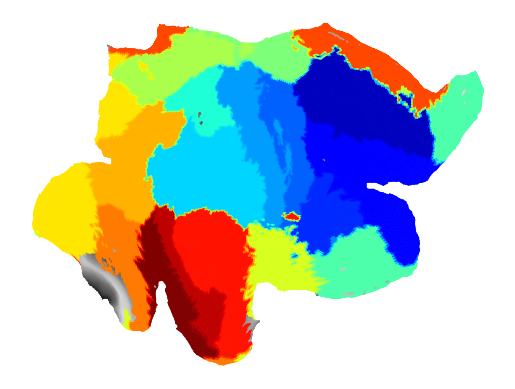

In [345]:
ax = surf.plot.plotmap(data = surf_roi_dummy, 
                       surf = f"fs{surf_resolution}k_{surf_hemisphere}",
                       threshold = 0.01)

# ROI - text

- 최대한 많이 뭉쳐있는데에 배치해야 (Vertex cluster 분석)
    - 최대 cluster가 존재하는 곳에 Text 배치
- Color opacity 주면 좋을듯

In [346]:
uq_roi_value = np.unique(surf_roi_dummy)
uq_roi_value = uq_roi_value[uq_roi_value != 0]

In [347]:
seed_idx = 0

mean_vertex_loc_info = {} 
for roi_name, roi_value in zip(roi_nick_names, uq_roi_value):
    vertex_locs = vertex_data[surf_roi_dummy == roi_value][:, :2] # xy coordinates
    if roi_name in ["OB", "ParaC", "PC"]:
        region = region_growing(vertex_locs, seed_idx, threshold=10)
    else:
        region = vertex_locs
    
    mean_vertex_loc = list(np.mean(region, axis = 0))
    mean_vertex_loc_info[roi_name] = mean_vertex_loc


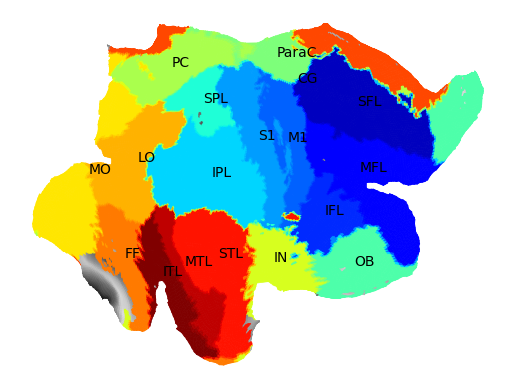

In [348]:

"""
x_min, x_max = int(ax.get_xlim()[0]), int(ax.get_xlim()[1])
y_min, y_max = int(ax.get_ylim()[0]), int(ax.get_ylim()[1])

x_count = 20
y_count = 20
x_interval = (x_max - x_min) / x_count
y_interval = (y_max - y_min) / y_count
ax.set_xticks(np.arange(x_min, x_max, x_interval).astype(int))
ax.set_xticklabels(np.arange(x_min, x_max, x_interval).astype(int), rotation = 90)

ax.set_yticks(np.arange(y_min, y_max, y_interval).astype(int))
ax.set_yticklabels(np.arange(y_min, y_max, y_interval).astype(int), rotation = 0)
"""
for i, roi_name in enumerate(mean_vertex_loc_info):
    loc = mean_vertex_loc_info[roi_name]
    ax.text(x = loc[0], y = loc[1], s = roi_name)
ax.get_figure()